In [4]:
import numpy as np
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from glob import glob
import torchaudio
import math
import librosa.display

In [35]:
def get_zcr(x,sr,frame_length=25,hop_length=10):
    frame_arr = librosa.util.frame(x,frame_length,hop_length,axis = 0)
    cross_arr = librosa.zero_crossings(frame_arr, threshold = -1)
    return np.mean(cross_arr, axis = -1)

def unionise(transcript_list): #Collapse intervals like (1,2),(2,3) into (1,3)
    new_list = []
    for interval in transcript_list:
        start_pt = interval[0]
        end_pt = interval[1]
        final_elt = [-2,-1]
        if new_list:
            final_elt = new_list[-1]
        if final_elt[1] == start_pt:
            new_list[-1] = [final_elt[0],end_pt]
        else:
            new_list.append([start_pt,end_pt])
    return new_list

def get_transcripts(zcr_arr,rms_arr,zcr_t,rms_t, frame_length = 25, frame_hop=10,sr = 22050, min_interval = 1): 
    #Returns the transcripts given by the threshold algorithm. zcr_t and rms_t are the thresholds. It returns those
    # as voice segments which satisfy both the zcr threshold AND the rms threshold
    transcript_list = []
    on_flag = 0
    for i in range(zcr_arr.size):
        if((zcr_arr[i] <= zcr_t and rms_arr[i] > rms_t) and on_flag== 0):
            start_time = float(math.floor((frame_hop*i/sr))) #convert everything to seconds
            on_flag = 1
        if((zcr_arr[i] > zcr_t or rms_arr[i] <= rms_t) and on_flag == 1):
            end_time= float(math.floor(((frame_hop*(i-1)/sr)))) #convert everything to seconds
            if (end_time - start_time) > min_interval:
                on_flag = 0
                transcript_list.append([start_time,end_time])
    return unionise(transcript_list)

def is_in_interval(arr,idx): #arr is an array with each element being a tuple corresponding to an interval
    #function checks whether idx is in any interval in the list
    if not arr:
        return 0
    for pair in arr:
        start = pair[0]
        end = pair[1]
        if(start <= idx and end >=idx):
            return 1
    return 0

def get_frame_error_rate(x,y_hat, y,sr = 22050):
    #Gets frame error rate - sums false positives and false negatives
    n = int(x.size//sr)
    err = 0
    for i in range(n):
        if(is_in_interval(y_hat,i) + is_in_interval(y,i) == 1): #This if condition means it is either a false positive or false negative - exactly one of the two is in the interval
            err = err + 1
    return 100*(err/n)

def get_plots(x,zcr,rms,index = 0, time_slice = 1000000, t = 45): #plots audio, zcr, and rms for one sample
    #The time indices used are from index*time_slice to (index+1)*time_slice
    print("New Sample")
    jump = int(sr*t//10)
    plt.figure(figsize=(14,5))
    fig,(ax1,ax2,ax3) = plt.subplots(3,1)
    librosa.display.waveshow(x[index*time_slice:(index+1)*time_slice],sr, ax = ax1)
    ax2.plot(rms[index*jump:(index+1)*jump])
    ax3.plot(zcr[index*jump:(index+1)*jump])
    plt.show()
    return

def get_stats(x,zcr,rms, bins = 10):
    get_plots(x,zcr,rms)
    softening = 1e-9
    print("Stats for ZCR:")
    print(pd.DataFrame(zcr).describe())
    print("Stats for RMS:")
    print(pd.DataFrame(rms).describe())
    plt.figure(figsize=(14,5))
    fig,(ax1,ax2) = plt.subplots(2,1)
    ax1.hist(np.histogram(zcr, bins = bins, density = True), bins = bins)
    print("Histogram for RMS:")
    ax2.hist(np.histogram(rms, bins = bins, density = True), bins = bins)
    return


def get3dplots(frame_error_rate_list,zcr_threshold_list,rms_threshold_list,iteration, file_extension = '.png'):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(111, projection = '3d')
    n = len(zcr_threshold_list)
    m = len(rms_threshold_list)
    my_idx = 0
    #for zcr_elt in zcr_threshold_list:
    #    for rms_elt in rms_threshold_list:
    #        ax.scatter3D(zcr_elt, rms_elt, frame_error_rate_list[my_idx])
    #        my_idx = my_idx+1
    x1,y1 = np.meshgrid((zcr_threshold_list), (rms_threshold_list))
    print(np.shape((zcr_threshold_list)), np.shape((rms_threshold_list)), np.shape(frame_error_rate_list))
    ax.plot_surface(x1,y1,frame_error_rate_list.reshape([m,n]),cmap = 'Spectral')
    ax.set_xlabel("ZCR-Threshold")
    ax.set_ylabel("RMS-Threshold")
    ax.set_zlabel("Frame Error Rate")
    ax.set_title("Frame Error Rate for Different Thresholds")
    plt.show()
    plt.savefig('/project/graziul/threshold_plots/frame_error_rate_' + str(iteration) + file_extension)
    return

def process_single_file(x, label, sr, zcr_threshold, rms_threshold):
    print("ZCR Threshold = " + str(zcr_threshold) + " RMS Threshold = " + str(rms_threshold))
    transcript_list = get_transcripts(zcr,rms,zcr_threshold,rms_threshold,frame_size,frame_hop,sr, 0.3)
    print("The frame error rate is: ", end = '')
    frame_error_rate = get_frame_error_rate(x,transcript_list, label,sr)
    print(frame_error_rate)
    return frame_error_rate

In [6]:
data_dir = '/project/graziul/data/Zone1/2018_08_04'
audio_list = glob(data_dir + '/*.mp3')
print(audio_list)

clean_df = pd.read_csv('/project/graziul/transcripts/df_va2021_09_17.csv')
df_groups = clean_df.groupby(['zone','date','filename'])

['/project/graziul/data/Zone1/2018_08_04/201808042032-193789-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041434-67097-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041703-149997-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041404-696986-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041135-540482-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808042231-612241-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041733-277547-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041234-536320-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808040836-586337-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808042102-541890-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808042201-380390-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041504-822552-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808040935-23455-27730.mp3', '/project/graziul/data/Zone1/2018_08_04/201808041334-370955-27730

In [ ]:
max_zcr_t = -100
min_zcr_t = 100
max_rms_t = -100
min_rms_t = 100
for state,frame in df_groups: #iterate over each .mp3 and compute zcr,rmse and find frame error rate(not done yet)
    '''if(idx > 1): #restricting to one sample for now, can be deleted once the code is working
        print('done') 
        break'''
    info_list = list(state)
    idx = idx+1
    audio_file = '/project/graziul/data/' + info_list[0] + '/' + info_list[1] + '/' + info_list[2]
    print(audio_file)
    try:
        x,sr = torchaudio.load(audio_file)
        x = np.squeeze(x.numpy())
        zcr = np.array(np.squeeze(librosa.get_zcr(x,sr, frame_length=sr*frame_size,hop_length=sr*frame_hop)))
        rms = np.array(np.squeeze(librosa.feature.rms(x,frame_length=sr*frame_size,hop_length=sr*frame_hop)))
        min_zcr_t = np.min(min_zcr_t, np.min(zcr))
        min_rms_t = np.min(min_rms_t, np.min(rms))
        max_zcr_t = np.max(max_zcr_t, np.max(zcr))
        max_rms_t = np.max(max_rms_t, np.max(zcr))
    except:
        pass

/project/graziul/data/Zone1/2018_08_04/201808042331-339616-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050001-100238-27730.mp3


formats: can't open input file `/project/graziul/data/Zone1/2018_08_04/201808042331-339616-27730.mp3': No such file or directory


/project/graziul/data/Zone1/2018_08_05/201808050031-739899-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050100-298054-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050130-950381-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050330-822967-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050359-300564-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050429-961171-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050459-276291-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050529-298280-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050559-512509-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050758-615610-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050828-792675-27730.mp3
/project/graziul/data/Zone1/2018_08_09/201808092351-896112-27730.mp3
/project/graziul/data/Zone1/2018_08_10/201808100021-669974-27730.mp3


formats: can't open input file `/project/graziul/data/Zone1/2018_08_09/201808092351-896112-27730.mp3': No such file or directory


/project/graziul/data/Zone1/2018_08_10/201808100051-862340-27730.mp3
/project/graziul/data/Zone1/2018_08_10/201808100121-608175-27730.mp3
/project/graziul/data/Zone1/2018_08_10/201808100151-536595-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111508-661302-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111538-917671-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111608-178189-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111638-648911-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111708-685990-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111737-609665-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111807-883152-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111837-315775-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111907-423587-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808111937-459173-27730.mp3
/project/graziul/data/Zone1/2018_08_11/201808112007-612624-27730.mp3
/project/graziul/data/Zone1/2018_0

formats: can't open input file `/project/graziul/data/Zone1/2018_08_11/201808112335-560782-27730.mp3': No such file or directory


/project/graziul/data/Zone1/2018_08_12/201808120035-587214-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120105-889671-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120135-851247-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120205-953882-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120234-654163-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120304-366043-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120404-252508-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120504-981165-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120533-329786-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120603-647711-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120633-901759-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120703-852547-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120733-369191-27730.mp3
/project/graziul/data/Zone1/2018_08_12/201808120803-891554-27730.mp3
/project/graziul/data/Zone1/2018_0

In [12]:
zcr_list = []
rms_list = []
autocorrelation_list = []
labels_list = []
audio_file_arr = []
frame_size = 25
frame_hop = 10
idx = 0
transcript_list_arr = []
zcr_t_arr = np.linspace(min_zcr_t,max_zcr_t,20)
#zcr_threshold = 1
rms_t_arr = np.linspace(min_rms,max_rms_t,100)

txtfile = open('/project/graziul/ra/ajays/stats.txt','w')
txtfile.truncate(0)
for state,frame in df_groups: #iterate over each .mp3 and compute zcr,rmse and find frame error rate(not done yet)
    '''if(idx > 1): #restricting to one sample for now, can be deleted once the code is working
        print('done') 
        break'''
    info_list = list(state)
    idx = idx+1
    audio_file = '/project/graziul/data/' + info_list[0] + '/' + info_list[1] + '/' + info_list[2]
    print(audio_file)
    start_voice_list = list(frame['start_voice'])
    end_voice_list = list(frame['end_voice'])
    try:
        x,sr = torchaudio.load(audio_file)
        x = np.squeeze(x.numpy())
        label = list(zip(start_voice_list,end_voice_list))
        labels_list.append(label)
        audio_file_arr.append(x)
        zcr = np.array(np.squeeze(librosa.get_zcr(x,sr, frame_length=sr*frame_size,hop_length=sr*frame_hop)))
        zcr_list.append(zcr)
        rms = np.array(np.squeeze(librosa.feature.rms(x,frame_length=sr*frame_size,hop_length=sr*frame_hop)))
        rms_list.append(rms)
        get_plots(x,zcr,rms)
        frame_error_rate_list = []
        for zcr_threshold in zcr_t_arr:
            for rms_threshold in rms_t_arr:
                frame_error_rate = process_single_file(x,label,sr,zcr_threshold,rms_threshold)
                frame_error_rate_list.append(frame_error_rate)
                writeline = audio_file + ' ' + str(zcr_threshold) + ' ' + str(rms_threshold) + ' ' + str(frame_error_rate) + '\n'
                txtfile.write(writeline)
        frame_error_rate_list = np.array(frame_error_rate_list)
        get3dplots(frame_error_rate_list, zcr_t_arr, rms_t_arr,idx)       
        #plt.plot(rms_t_arr,frame_error_rate_list)
        #plt.xlabel('RMS Threshold')
        #plt.ylabel('Frame Error Rate')
        #plt.savefig('/project/graziul/ra/ajays/rms_plots/frame_error_rate_' + str(idx) + '.png')
    except Exception as e:
        print(e)
        pass
txtfile.close()

/project/graziul/data/Zone1/2018_08_04/201808042331-339616-27730.mp3
Error loading audio file: failed to open file /project/graziul/data/Zone1/2018_08_04/201808042331-339616-27730.mp3
/project/graziul/data/Zone1/2018_08_05/201808050001-100238-27730.mp3


formats: can't open input file `/project/graziul/data/Zone1/2018_08_04/201808042331-339616-27730.mp3': No such file or directory


KeyboardInterrupt: 

New Sample


<Figure size 1008x360 with 0 Axes>

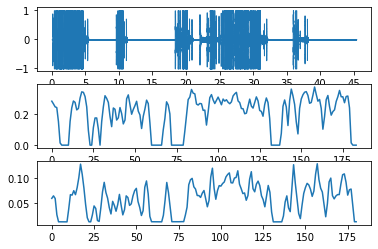

Stats for ZCR:
                0
count  181.000000
mean     0.057698
std      0.031753
min      0.011220
25%      0.028236
50%      0.063400
75%      0.080506
max      0.128479
Stats for RMS:
                0
count  184.000000
mean     0.205048
std      0.114536
min      0.000936
25%      0.136342
50%      0.242823
75%      0.290557
max      0.376626
Histogram for RMS:


<Figure size 1008x360 with 0 Axes>

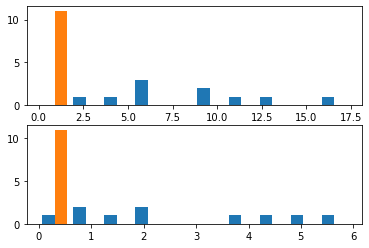

In [32]:
test_dir = '/project/graziul/data/Zone1/2018_08_05/201808050001-100238-27730.mp3'
x,sr = torchaudio.load(test_dir)
x = np.squeeze(x.numpy())
zcr = np.array(np.squeeze(get_zcr(x,sr, frame_length=sr*frame_size,hop_length=sr*frame_hop)))
rms = np.array(np.squeeze(librosa.feature.rms(x,frame_length=sr*frame_size,hop_length=sr*frame_hop)))
get_stats(x,zcr,rms)

In [28]:
my_zcr = get_zcr(x,sr,frame_size,frame_hop)

In [29]:
set(my_zcr)

{0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52}

In [ ]:
plt.hist(x, bins = 50)
arr = plt.hist(zcr, bins = 50)
zcr_t_list = arr[1][np.nonzero(arr[0])]
plt.hist(rms[rms>0.1], bins = 50)

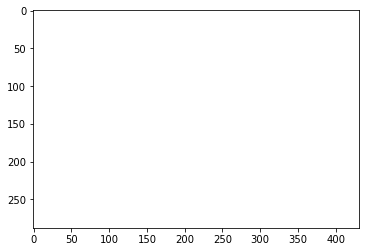

In [10]:
from PIL import Image
from scipy import misc
import numpy as np
img_num = 2
img_path = '/project/graziul/ra/ajays/ajay_plots/frame_error_rate_' + str(img_num) +'.png'
img = Image.open(img_path)
img = np.array(img)
plt.imshow(img)

In [ ]:
def f(x,y):
    return np.sin(np.sqrt(x**2 + y**2))

x = np.linspace(-6,6,30)
y = np.linspace(-5,5,20)
print(x.shape,y.shape)
x,y = np.meshgrid(x,y)
z = f(x,y)
print(z.shape)
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111, projection = '3d')
ax.contour3D(x,y,z,50)